# 자동차 파손 영역 검사 및 가격 산출 AI 만들기

In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

filepath = '/content/gdrive/My Drive/car/'
model_filepath = '/content/gdrive/My Drive/car/src/'
image_filepath = '/content/gdrive/My Drive/car/samples/damage/'

import sys
sys.path.append(model_filepath)

#from torchvision.models import resnet34
from Models import Unet


# 여러 형태의 파손 영역 감지

> 인용구 추가



In [ ]:
labels = ['Breakage_3', 'Crushed_2', 'Scratch_0', 'Seperated_1'] #찢어짐, 찌그러짐, 스크레치, 이격
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for label in labels:
    #model_path = f'models/[DAMAGE][{label}]Unet.pt'
    model_path = f'{filepath}models/[DAMAGE][{label}]Unet.pt'


    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded pretrained models!')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]


Loaded pretrained models!


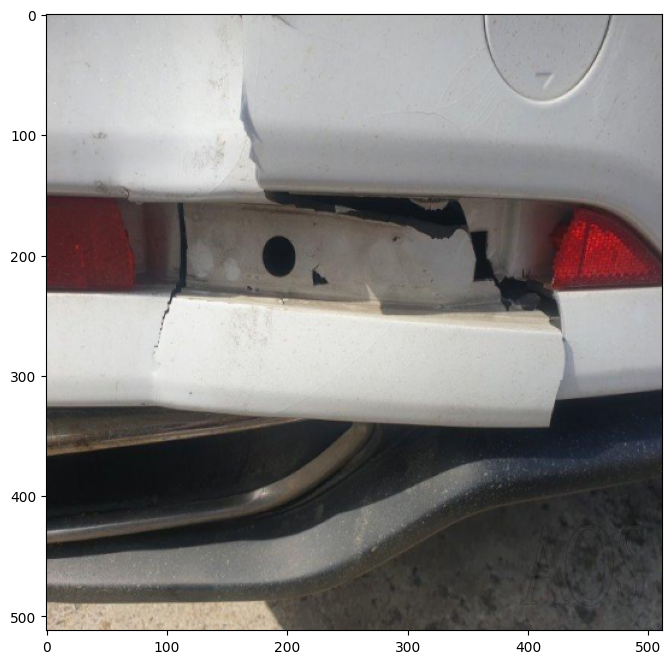

In [ ]:
img_path = image_filepath + '0000076_as-0035111.jpg'

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))

plt.figure(figsize=(8, 8))
plt.imshow(img)

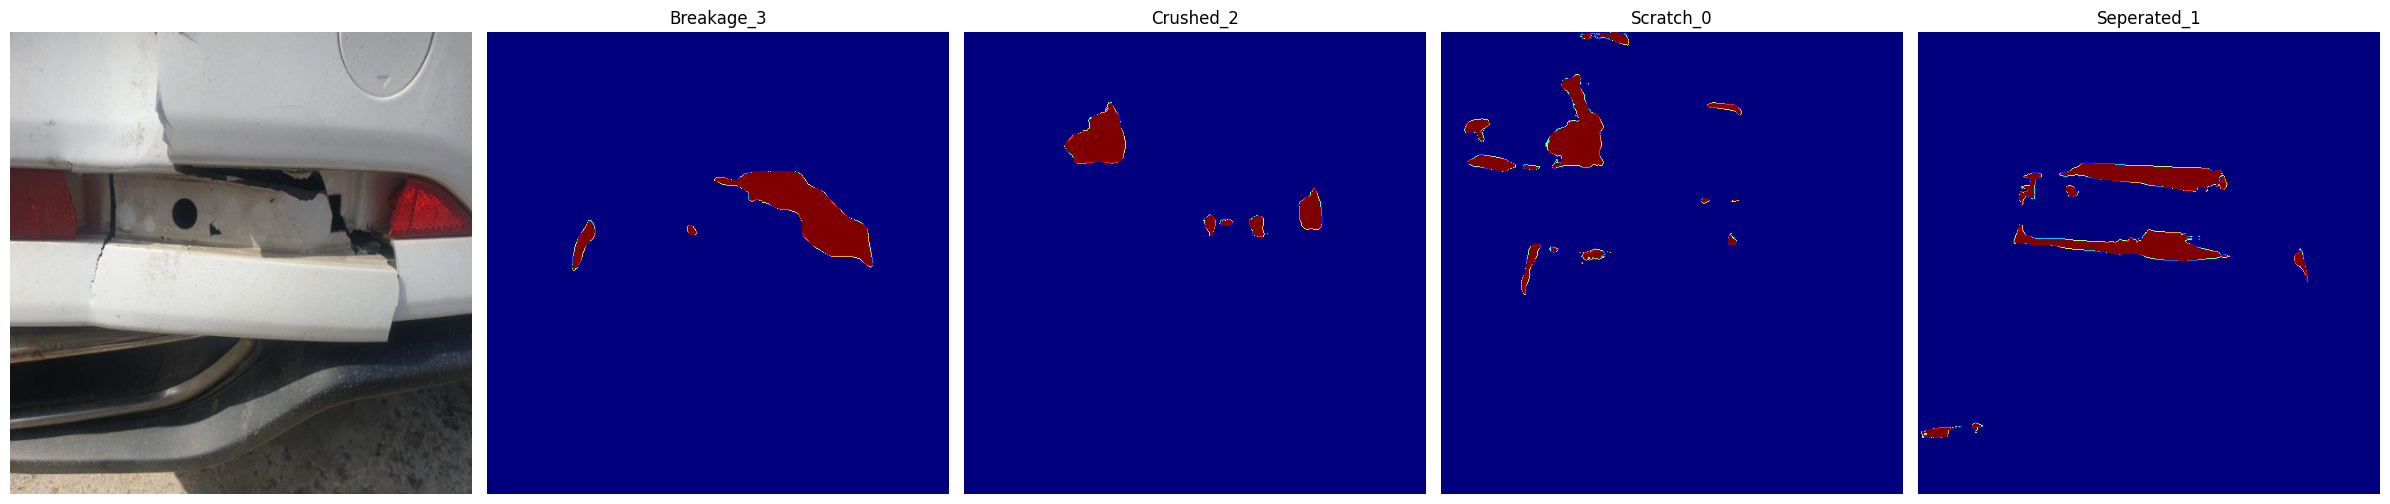

In [ ]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

##  파손 영역 크기 계산

In [ ]:
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage_3: 2433
Crushed_2: 19529
Scratch_0: 50562
Seperated_1: 6475


## 파손 영역 크기에 따른 가격 산출 (예시)

1픽셀당 가격을 책정하여 영역이 넓을 수록 수리비용이 비싸진다

In [ ]:
price_table = [
    100, # Breakage_3
    200, # Crushed_2
    50,  # Scratch_0
    120, # Seperated_1
]

total = 0

for i, price in enumerate(price_table):
    area = outputs[i].sum()
    total += area * price

    print(f'{labels[i]}:\t영역: {area}\t가격:{area * price}원')

print(f'빵형 고객님, 총 수리비는 {total}원 입니다!')

Breakage_3:	영역: 2433	가격:243300원
Crushed_2:	영역: 19529	가격:3905800원
Scratch_0:	영역: 50562	가격:2528100원
Seperated_1:	영역: 6475	가격:777000원
빵형 고객님, 총 수리비는 7454200원 입니다!


Breakage_3:	영역: 3475	가격:347500원
Crushed_2:	영역: 2447	가격:489400원
Scratch_0:	영역: 17920	가격:896000원
Seperated_1:	영역: 5365	가격:643800원
빵형 고객님, 총 수리비는 2376700원 입니다!
[7]
0초
